## Torch 라이브러리 연습

Torch 라이브러리의 구조도 좀 파악할 겸 파이썬 자체에도 좀 익숙해지기 위해, 특히 순방향 신경망 학습에 필요한 문법들을 효율적으로 활용할 수 있는 사용자 정의 클래스와 루틴들을 짜 보는 연습을 해 보았습니다.

학습용 데이터셋은 Cora 그래프 데이터를 활용했습니다.

In [4]:
################ INITIALIZING AND LOADING DATASET #################

import torch as t
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
cora_data = dataset[0]
setattr(cora_data,"num_classes",dataset.num_classes)

$\downarrow$ 보통 torch의 간단한 순방향 레이어의 인스턴스 선언은 {Layername}({inchannel},{outchannel}, {varargs}) 와 같은 형태이므로 (이는 퍼셉트론의 전형적인 리니어 레이어들의 변종이나, convolutional layer, 그리고 GCN의 Graph Convolution Layer등도 비슷한 문법을 가졌습니다) 필요한 인수들만 정리해 준다면 바로 인스턴스를 선언해 줄 수 있도록 만들어 봤습니다. 모델 클래스 내엔 항상 forward message passing을 위한 *forward* 함수가 정의되어야 하는데, 레이어마다 forward에 필요한 인수가 다르므로, 이것도 'fw_option=' 을 이용해 넣을 수 있도록 해 봤습니다. 추가로, Dropout의 빈도와 여부도 결정할 수 있도록 인수로 넣을 수 있게 만들었습니다.

In [5]:
################ CLASS OF FEED-FORWARD NEURAL NETS ################

class FFNN(t.nn.Module):
  
  def __init__(self, layers, activations, hidden_channels, data, 
               layer_options=False, fw_options=False, dropouts=False):
    super(FFNN,self).__init__()
    t.manual_seed(1234567)
    
    self.data = data
    self.activations = activations
    self.fw_options = fw_options
    self.dropouts = dropouts
    self.num_layers = len(layers)
    
    if layer_options == False:
      self.layer_options = [[] for i in range(self.num_layers)]
    if fw_options == False:
      self.fw_options = [[] for i in range(self.num_layers)]
      
    self.channels = hidden_channels
    self.channels.insert(0,self.data.num_features); 
    self.channels.append(self.data.num_classes)
    
    self.layers = [ ]
    for i in range(0,self.num_layers):
      args = [self.channels[i],self.channels[i+1]]; args.extend(self.layer_options[i])
      self.layers.append( layers[i]( *args ) )
    self.layers = t.nn.ModuleList(self.layers)
    
  def forward(self, x):
    for i in range(0,self.num_layers):
      args = [x]; args.extend(self.fw_options[i])
      x = self.activations[i]( self.layers[i]( *args ))
      if self.dropouts is not False:
        x = F.dropout(x, p=self.dropouts[i], training=self.training)
      else:
        pass
    return x

$\downarrow$ 앞서 정의한 FFNN 모델 클래스의 인스턴스를 이용해 간편히 학습을 시작하고, torch가 학습을 수행하는 과정을 모니터링 할 수 있도록 과정 중 정보를 저장하는 'learn'이라는 클래스도 만들어 보았습니다. 이 클래스는 1-epoch학습을 위한 train_onestep 메쏘드와 accuracy 확인을 위한 get_accuracy 메쏘드를 가지고 있습니다. 언제든 필요 시 확인해 볼 수 있게 self.attribute로 학습 중의 각 training, validation, 및 test set에 대한 loss와 accuracy를 시계열 형태로 저장해 놓을 수 있도록 만들었습니다.

In [6]:
################ LEARNING & TESTING ROUTINE #################

class learning:
  def __init__(self, model, optimizer, criterion, epochs, data):
    
    self.data = data
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.epochs = t.arange(1,epochs+1)
    loss_vec = t.zeros((3,epochs)); acc_vec = t.zeros((3,epochs))
    
    for epoch in range(0,epochs):
      loss_vec[:,epoch], self.out = self.train_onestep()
      acc_vec[:,epoch] = self.get_accuracy()
  
    print("\n############################## LEARNING FINISHED! ##################################\n")
    
    self.train_loss = loss_vec[0,:]; self.train_acc = acc_vec[0,:]
    self.val_loss = loss_vec[1,:]; self.val_acc = acc_vec[1,:]
    self.test_loss = loss_vec[2,:]; self.test_acc = acc_vec[2,:]
    
    print(f'Test Accuracy: {self.test_acc[-1]:.4f}')
    
  def train_onestep(self):
    
    self.model.train()
    self.optimizer.zero_grad()
    out = self.model.forward(self.data.x)
    
    train_loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
    val_loss = self.criterion(out[self.data.val_mask], self.data.y[self.data.val_mask])
    test_loss = self.criterion(out[self.data.test_mask], self.data.y[self.data.test_mask])
    train_loss.backward() 
    self.optimizer.step()  
    
    return t.tensor([train_loss, val_loss, test_loss]), out
  
  def get_accuracy(self):
    
    self.model.eval()
    out = self.model.forward(self.data.x)
    pred = out.argmax(dim=1) 
    
    train_correct = pred[self.data.train_mask] == self.data.y[self.data.train_mask]
    val_correct = pred[self.data.val_mask] == self.data.y[self.data.val_mask]
    test_correct = pred[self.data.test_mask] == self.data.y[self.data.test_mask]
    
    train_acc = int(train_correct.sum()) / int(self.data.train_mask.sum())
    val_acc = int(val_correct.sum()) / int(self.data.val_mask.sum())
    test_acc = int(test_correct.sum()) / int(self.data.test_mask.sum())
    
    return t.tensor([train_acc, val_acc, test_acc])

$\downarrow$ 위의 learn 클래스의 인스턴스로 담겨진 학습 과정 정보들을 시각화해주는 함수를 만들어 보았습니다. loss 와 accuracy의 시계열 플롯 루틴, 그리고 고차원의 output벡터들을 2D 프로젝션으로 보여주는 TSNE플롯 루틴을 가지고 있습니다.

In [7]:
from sklearn.manifold import TSNE

############### VISUALIZING ROUTINE ################

def visualize(result, progress_plot=True, TSNE_plot=False):

  if progress_plot is True:
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(15,5)
    fig.suptitle("Learning Result", fontsize = 15)
    
    loss1, = ax[0].plot( result.epochs, result.train_loss, color='b', linewidth=2 , label = "Train set")
    loss2, = ax[0].plot( result.epochs, result.val_loss, color='g', linewidth=2 , label = "Validation set")
    loss3, = ax[0].plot( result.epochs, result.test_loss, color='r', linewidth=2, label = "Test set" )
    ax[0].legend(handles = [loss1, loss2, loss3])
    ax[0].set_xlabel("Epochs")
    ax[0].set_title("Loss")

    acc1, = ax[1].plot( result.epochs, result.train_acc, color='b', linewidth=2, label = "Train set")
    acc2, = ax[1].plot( result.epochs, result.val_acc, color='g', linewidth=2, label = "Validation set" )
    acc3, = ax[1].plot( result.epochs, result.test_acc, color='r', linewidth=2, label = "Test set" )
    ax[1].legend(handles = [loss1, loss2, loss3])
    ax[1].set_xlabel("Epochs")
    ax[1].set_title("Accuracy")
    plt.show()
  else:
    pass
  
  if TSNE_plot is True:
    z = TSNE(n_components=2).fit_transform(result.out.detach().cpu().numpy())
    fig,ax = plt.subplots()
    fig.set_size_inches(7,7)
    ax.set_title('2D projection of model output',fontsize=12)
    ax.scatter(z[:,0], z[:,1], s=70, c=result.data.y, cmap="Set2")
    plt.show()
  else:
    pass

$\downarrow$ 이제 연습삼아 열심히 만들어 본 루틴들로 간편히 학습과 결과 모니터링을 해 보았습니다. 

첫 실험으론 ReLU activation을 갖는 단순한 1-hidden layer MLP를 실체화하고 학습해 보았습니다.

* *Validation set을 모니터링하며 적절한 stopping을 하는 criterion을 적용하는 연습은 빠르게 다음 주제로 다뤄 보겠습니다.*

Current model: 
FFNN(
  (layers): ModuleList(
    (0): Linear(in_features=1433, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=7, bias=True)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.5920


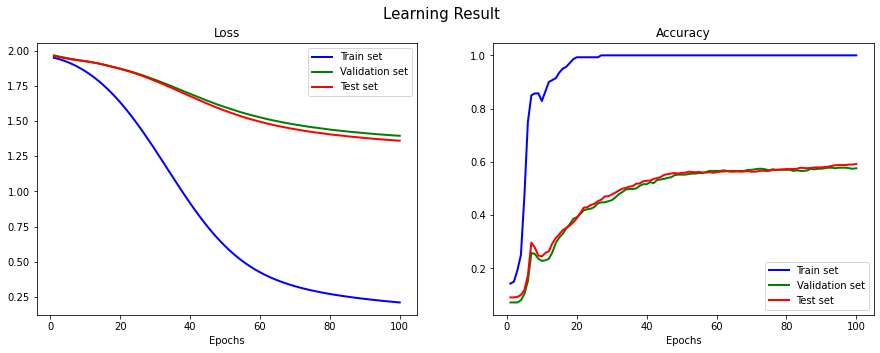

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


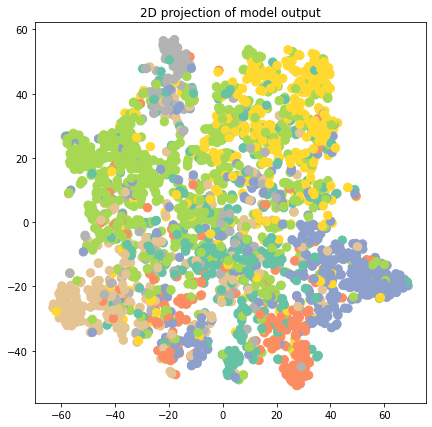

In [26]:
################# CONSTRUCTING MODEL AND LEARNING ##################

data = cora_data
model = FFNN( layers = [t.nn.Linear, t.nn.Linear],
            activations = [ F.relu, t.nn.Identity() ],
            hidden_channels = [ 16 ],
            data = data); print(f"Current model: \n{model}")

result = learning( model = model, 
                   optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                   criterion = t.nn.CrossEntropyLoss(), 
                   epochs = 100,
                   data = data)

visualize(result,TSNE_plot=True)

학습이 잘 되지 않아 더 깊고 큰 MLP 모델과 output으로 softmax를 써 보았습니다.

Current model: 
FFNN(
  (layers): ModuleList(
    (0): Linear(in_features=1433, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=7, bias=True)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.3780


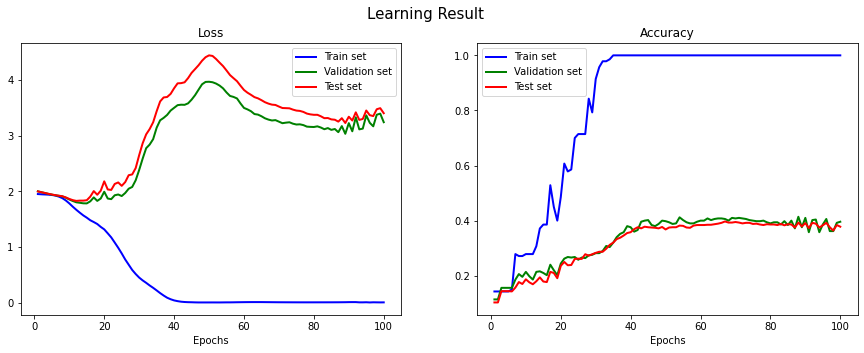

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


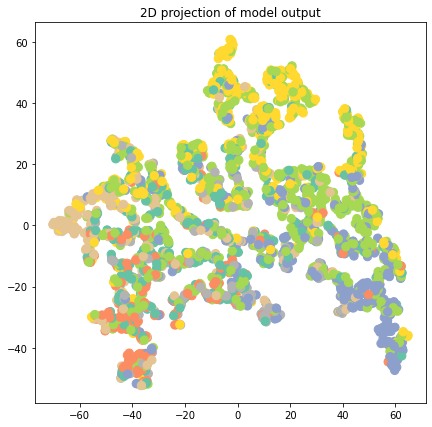

In [28]:
model = FFNN( layers = [t.nn.Linear, t.nn.Linear, t.nn.Linear, t.nn.Linear],
            activations = [ F.relu, F.relu, F.relu, t.nn.Identity() ],
            hidden_channels = [ 100, 100, 20 ],
            data = data); print(f"Current model: \n{model}")

result = learning( model = model, 
                   optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                   criterion = t.nn.CrossEntropyLoss(), 
                   epochs = 100,
                   data = data)

visualize(result,TSNE_plot=True)

왜인지 모르겠지만 모델이 커진다고 학습이 잘 되진 않는 것 같습니다...

다시 작은 모델로 전처리가 없었던 output에 softmax를 걸어보겠습니다.

Current model: 
FFNN(
  (layers): ModuleList(
    (0): Linear(in_features=1433, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=7, bias=True)
  )
)


C:\Users\echo_\AppData\Local\Temp\ipykernel_13108\20508920.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.activations[i]( self.layers[i]( *args ))



############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.4040


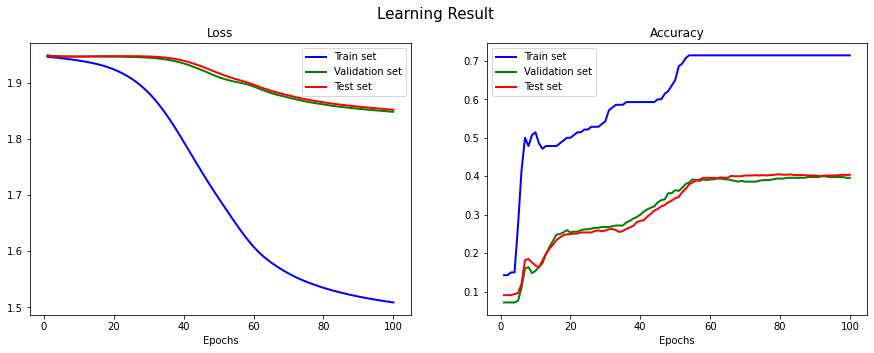

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


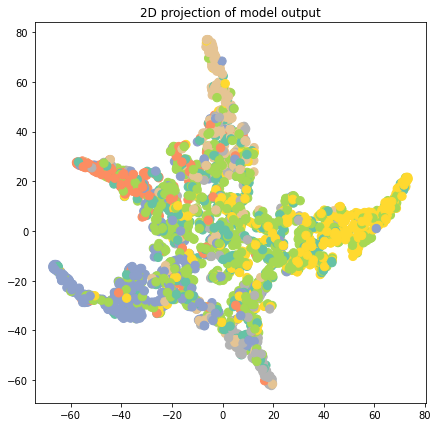

In [30]:
model = FFNN( layers = [t.nn.Linear, t.nn.Linear],
            activations = [ F.relu, F.softmax ],
            hidden_channels = [ 16 ],
            data = data); print(f"Current model: \n{model}")

result = learning( model = model, 
                   optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                   criterion = t.nn.CrossEntropyLoss(), 
                   epochs = 100,
                   data = data)

visualize(result,TSNE_plot=True)

Softmax가 output을 정제해 줌으로서 학습에 도움을 줄 줄 알았는데 이것도 이상하게도 더 성능이 떨어졌습니다. 

이번엔 Dropout을 추가해 봤습니다.

Current model: 
FFNN(
  (layers): ModuleList(
    (0): Linear(in_features=1433, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=7, bias=True)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.5840


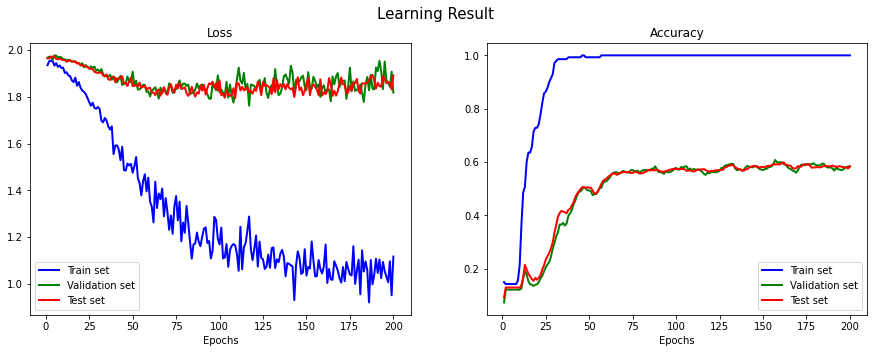

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


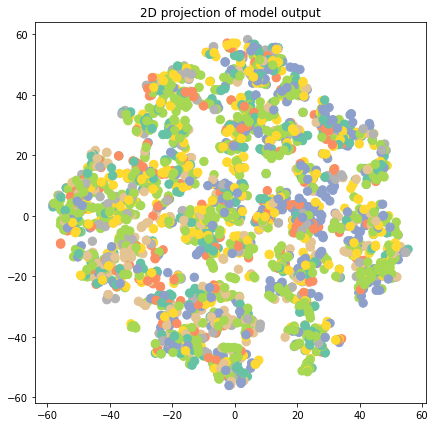

In [35]:
model = FFNN( layers = [t.nn.Linear, t.nn.Linear],
            activations = [ F.relu, t.nn.Identity() ],
            hidden_channels = [ 16 ],
            dropouts = 0.5*t.ones(2),
            data = data); print(f"Current model: \n{model}")

result = learning( model = model, 
                   optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                   criterion = t.nn.CrossEntropyLoss(), 
                   epochs = 200,
                   data = data)

visualize(result,TSNE_plot=True)

1/2 Dropout을 추가하고 Epoch을 두배로 늘려 보았습니다. 그런데 dropout이 없을 떄와는 다르게 Loss가 요동치는 현상이 발생하는 것을 확인할 수 있었습니다. 보통 dropout은 성능을 위해 추가한다고 들었는데, loss와 accuracy의 요동 때문에 제대로 stop하지 않으면 오히려 안 좋은 결과가 나올 수도 있을 것 같습니다.

이젠 Graph 구조를 반영하지 않고 학습하는 MLP 대신, GNN으로 학습해 보겠습니다. GNN도 일종의 FFNN으로 볼 수 있어서, edge_index 같은 요소만 fw_options에 추가해 주면, 만들었던 루틴들의 목적대로 코드에 적은 양의 수정만 하고 학습을 할 수 있었습니다.

Current model: 
FFNN(
  (layers): ModuleList(
    (0): GCNConv(1433, 16)
    (1): GCNConv(16, 7)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.8080


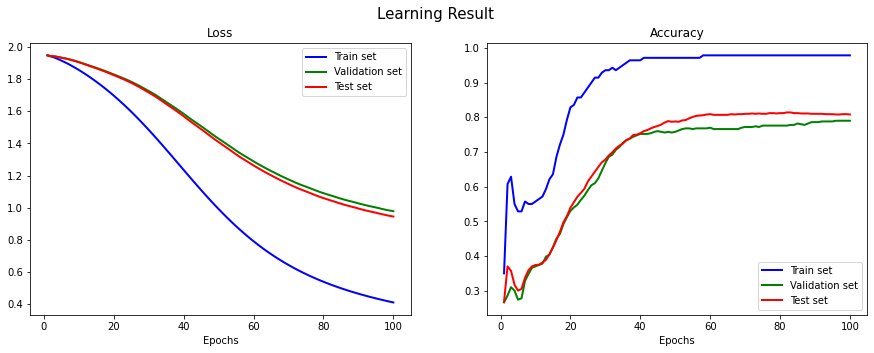

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


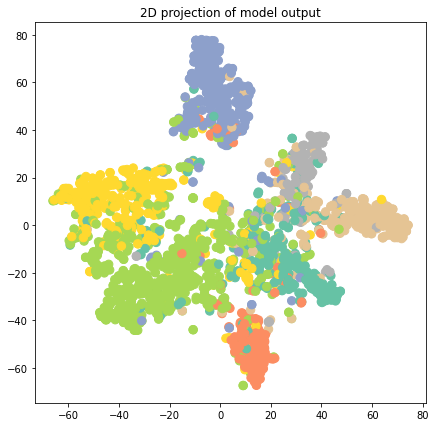

In [41]:
from torch_geometric.nn import GCNConv

model = FFNN( layers = [GCNConv, GCNConv],
            activations = [ F.relu, t.nn.Identity() ],
            fw_options = [ [data.edge_index], [data.edge_index] ],
            hidden_channels = [ 16 ],
            data = data); print(f"Current model: \n{model}")

result = learning( model = model, 
                   optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                   criterion = t.nn.CrossEntropyLoss(), 
                   epochs = 100,
                   data = data)

visualize(result,TSNE_plot=True)

MLP 보다 확실히 나은 성능입니다. 이젠 다시 dropout을 추가해 보겠습니다.

Current model: 
FFNN(
  (layers): ModuleList(
    (0): GCNConv(1433, 16)
    (1): GCNConv(16, 7)
  )
)

############################## LEARNING FINISHED! ##################################

Test Accuracy: 0.8100


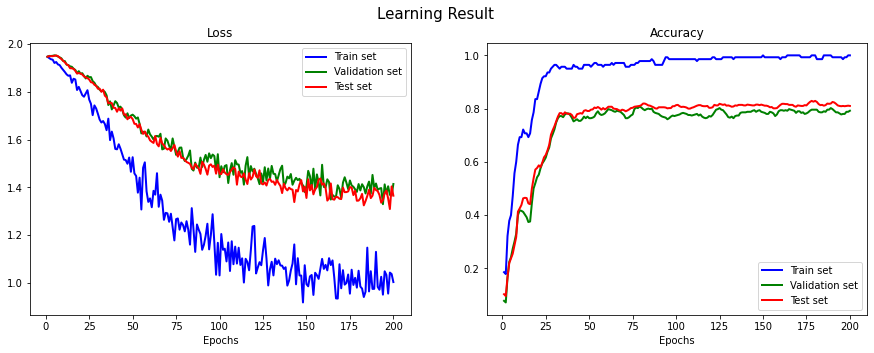

c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\echo_\miniconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


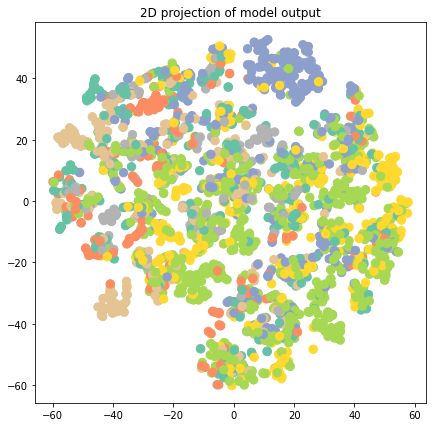

In [44]:
from torch_geometric.nn import GCNConv

model = FFNN( layers = [GCNConv, GCNConv],
            activations = [ F.relu, t.nn.Identity() ],
            fw_options = [ [data.edge_index], [data.edge_index] ],
            hidden_channels = [ 16 ],
            dropouts= 0.5*t.ones(2),
            data = data); print(f"Current model: \n{model}")

result = learning( model = model, 
                   optimizer = t.optim.Adam( model.parameters(), lr=0.01, weight_decay=5e-4 ), 
                   criterion = t.nn.CrossEntropyLoss(), 
                   epochs = 200,
                   data = data)

visualize(result,TSNE_plot=True)

역시 loss의 흔들림이 보였습니다. Dropout이 없을 때는 수렴하는 것 처럼 보이는 accuracy가, dropout이 추가되면 순간적으로 훨씬 좋아지는 순간들이 있는데, 차후에 dropout을 이용한 성능 향상과 validation set을 이용한 stopping을 연습해 보겠습니다.